# ДЗ №2 Гладышев В.В.

## Задание № 1

1.Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти".

Обозначения:
p - глубина истории, сколько измерений назад учитываем в моделях.
h - горизонт прогноза , на сколько измерений вперед смотрим при моделировании (как далеко предсказываем).

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np 
import pandas as pd 
import seaborn as sns

from sklearn.metrics import mean_squared_error


Bad key "text.kerning_factor" on line 4 in
C:\Users\viv232\anaconda3\envs\r_l\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [4]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [5]:
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [15]:
data['PJME_MW']

Date
2002-01-01    30393.0
2002-01-01    29265.0
2002-01-01    28357.0
2002-01-01    27899.0
2002-01-01    28057.0
               ...   
2018-08-02    44057.0
2018-08-02    43256.0
2018-08-02    41552.0
2018-08-02    38500.0
2018-08-03    35486.0
Name: PJME_MW, Length: 145374, dtype: float64

C:\Users\viv232\anaconda3\envs\r_l\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


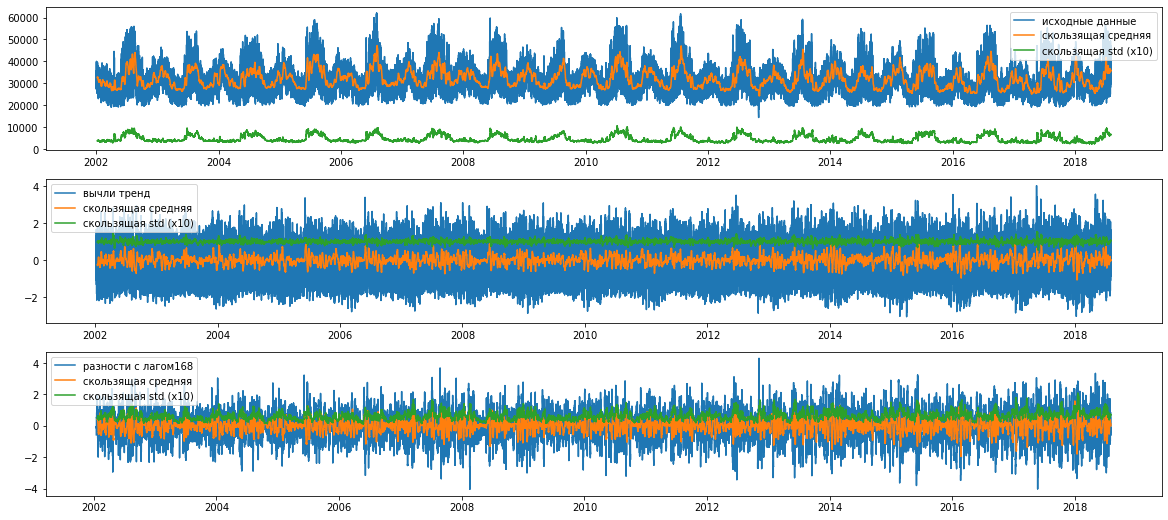

In [23]:
train = data.iloc[:-10, 1]
test = data.iloc[-10:, 1]

N2 = 24*7

data['z_data'] = (data['PJME_MW'] - data['PJME_MW'].rolling(window=N2).mean()) / data['PJME_MW'].rolling(window=N2).std()
data['zp_data'] = data['z_data'] - data['z_data'].shift(N2)

fig, ax = plt.subplots(3,figsize=(20, 9))
ax[0].plot(data.index, data['PJME_MW'], label='исходные данные')
ax[0].plot(data['PJME_MW'].rolling(window=N2).mean(), label="скользящая средняя");
ax[0].plot(data['PJME_MW'].rolling(window=N2).std(), label="скользящая std (x10)");
ax[0].legend()

ax[1].plot(data.index, data.z_data, label="вычли тренд")
ax[1].plot(data.z_data.rolling(window=N2).mean(), label="скользящая средняя");
ax[1].plot(data.z_data.rolling(window=N2).std(), label="скользящая std (x10)");
ax[1].legend()

ax[2].plot(data.index, data.zp_data, label="разности с лагом" +str(N2))
ax[2].plot(data.zp_data.rolling(window=N2).mean(), label="скользящая средняя");
ax[2].plot(data.zp_data.rolling(window=N2).std(), label="скользящая std (x10)");
ax[2].legend()

plt.show()

In [24]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

Text(0.5, 1.0, 'PJME_MW')

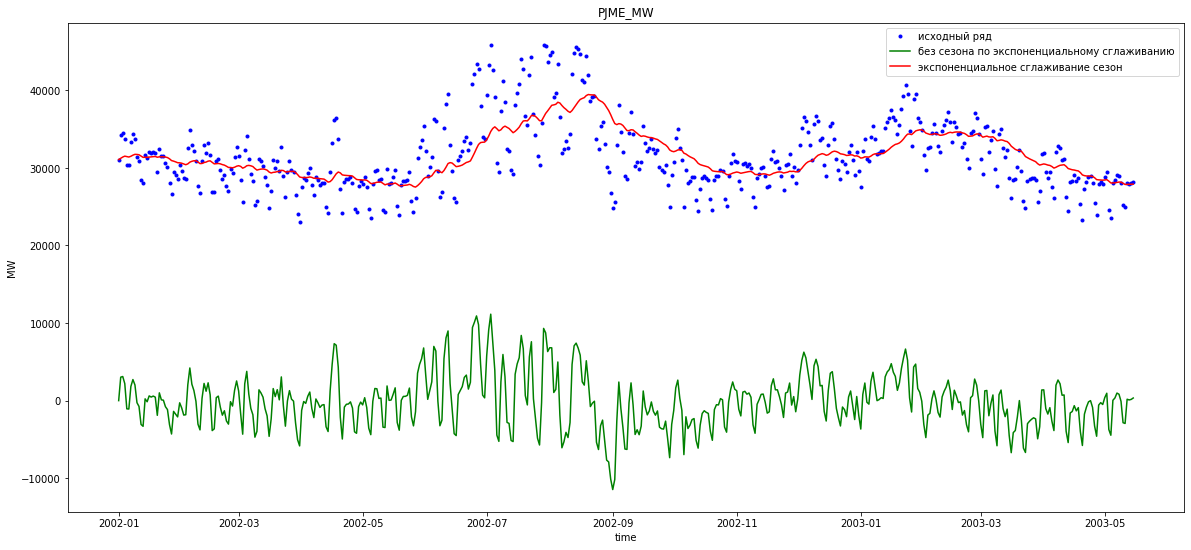

In [26]:
d_data=data.resample('D').mean()
data_exp_1 = exponential_smoothing(d_data['PJME_MW']  , 0.05)
plt.figure(figsize=(20, 9))
plt.plot(d_data.index[:500], d_data['PJME_MW'].values[:500], '.b',label='исходный ряд')

plt.plot(d_data.index[:500],d_data['PJME_MW'].values[:500] - data_exp_1[:500] , color = 'green', label="без сезона по экспоненциальному сглаживанию");

plt.plot(d_data.index[:500],data_exp_1[:500] , color = 'red', label="экспоненциальное сглаживание сезон");

plt.xlabel('time')
plt.ylabel('MW')
plt.legend()
plt.title('PJME_MW')

In [34]:
data_seson_free = pd.DataFrame(data = (np.array(d_data['PJME_MW']).reshape((d_data['PJME_MW'].shape[0],1)) -data_exp_1))
DF_ = sm.tsa.stattools.adfuller( data_seson_free.iloc[:,0] , regression = 'ctt')
DF_

(-8.36536213855966,
 4.282974615450982e-11,
 34,
 6024,
 {'1%': -4.373054660566805,
  '5%': -3.833370706612336,
  '10%': -3.55386764946938},
 107622.59914749119)

Сделали более стационарным

Text(0.5, 1.0, 'PJME_MW 2006-2017')

C:\Users\viv232\anaconda3\envs\r_l\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


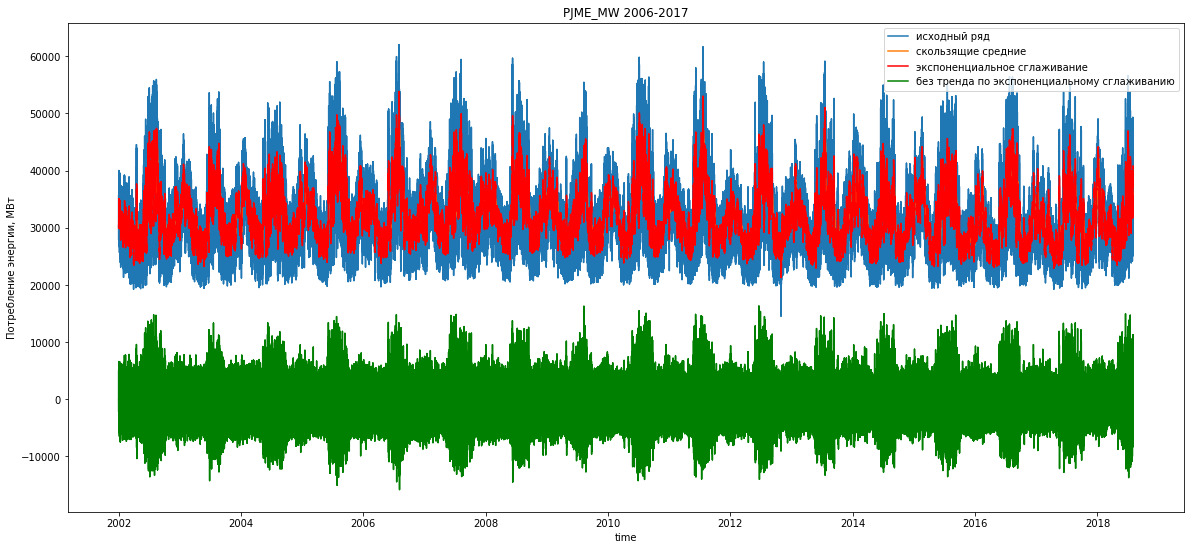

In [30]:
pw_ar_exp_1 = exponential_smoothing(data['PJME_MW'], 0.05)

plt.figure(figsize=(20, 9))
plt.plot(data.index, data['PJME_MW'], label='исходный ряд')
plt.plot(data['PJME_MW'].rolling(window=N2).mean(), label="скользящие средние");

plt.plot(data.index, pw_ar_exp_1, color = 'red', label="экспоненциальное сглаживание");
plt.plot(data.index, data['PJME_MW'] - pw_ar_exp_1, color = 'green', label="без тренда по экспоненциальному сглаживанию");
plt.xlabel('time')
plt.ylabel('Потребление энергии, МВт')
plt.legend()
plt.title('PJME_MW 2006-2017')

In [42]:
pw_ar_exp_1 = pd.DataFrame(data = pw_ar_exp_1, index = data.index)

## Feature Eneniring

In [44]:
df= pd.DataFrame(pw_ar_exp_1)
df.head()
 # добавили историю на глубину 8 измерения от текущего (р=8)
df['t'] = 0.0
df.iloc[1:,1]=df.iloc[:-1,0].values
df['t1']=0.0
df.iloc[2:,2]=df.iloc[:-2,0].values
df['t2']=0.0
df.iloc[3:,3]=df.iloc[:-3,0].values
df['t3'] = 0.0
df.iloc[4:,4]=df.iloc[:-4,0].values
df['t4']=0.0
df.iloc[5:,5]=df.iloc[:-5,0].values
df['t5']=0.0
df.iloc[6:,6]=df.iloc[:-6,0].values
df['t6'] = 0.0
df.iloc[7:,7]=df.iloc[:-7,0].values
df['t7']=0.0
df.iloc[8:,8]=df.iloc[:-8,0].values
df.fillna(0)
# добавили сглаживание (3 вида - просто для коллекции)
df['exp_0_01'] = exponential_smoothing(df[0], 0.01)
df['exp_0_03'] = exponential_smoothing(df[0], 0.03)
df['exp_0_08'] = exponential_smoothing(df[0], 0.08)
# добавим разности - 1-й порядок
df['diff1'] = 0.0
df['diff1'].iloc[1:] = df.iloc[:-1,0].values-df.iloc[1:,0].values

In [45]:
df.head(10)

,0,t,t1,t2,t3,t4,t5,t6,t7,exp_0_01,exp_0_03,exp_0_08,diff1
Date,,,,,,,,,,,,,
2002-01-01,30393.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000,0.00,0.0,30393.000000,30393.000000,30393.000000,0.000000
2002-01-01,30336.600000,30393.000000,0.000000,0.000000,0.000000,0.00000,0.000,0.00,0.0,30392.436000,30391.308000,30388.488000,56.400000
2002-01-01,30237.620000,30336.600000,30393.000000,0.000000,0.000000,0.00000,0.000,0.00,0.0,30390.887840,30386.697360,30376.418560,98.980000
2002-01-01,30120.689000,30237.620000,30336.600000,30393.000000,0.000000,0.00000,0.000,0.00,0.0,30388.185852,30378.717109,30355.960195,116.931000
2002-01-01,30017.504550,30120.689000,30237.620000,30336.600000,30393.000000,0.00000,0.000,0.00,0.0,30384.479039,30367.880732,30328.883744,103.184450
2002-01-01,29949.329322,30017.504550,30120.689000,30237.620000,30336.600000,30393.00000,0.000,0.00,0.0,30380.127541,30355.324190,30298.519390,68.175227
2002-01-01,29917.262856,29949.329322,30017.504550,30120.689000,30237.620000,30336.60000,30393.000,0.00,0.0,30375.498895,30342.182350,30268.018867,32.066466
2002-01-01,29901.149714,29917.262856,29949.329322,30017.504550,30120.689000,30237.62000,30336.600,30393.00,0.0,30370.755403,30328.951371,30238.669335,16.113143
2002-01-01,29903.242228,29901.149714,29917.262856,29949.329322,30017.504550,30120.68900,30237.620,30336.60,30393.0,30366.080271,30316.180097,30211.835166,-2.092514


## Модели

In [57]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
scl =StandardScaler()
scly =StandardScaler()

In [58]:
def split_data_b( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

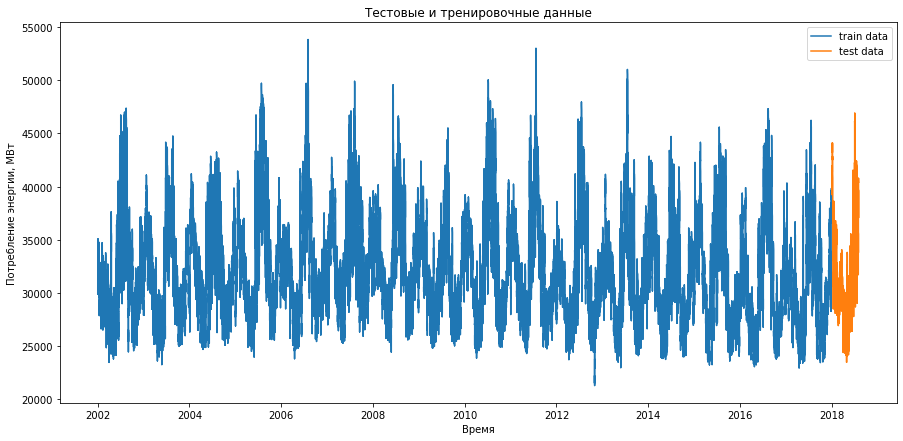

In [80]:
train_b, test_b = split_data_b( df, '31-12-2017')

h = 1

X_train_b = train_b.iloc[:-h,:]
y_train_b = train_b[df.columns[0]].values[h:]
X_test_b = test_b.iloc[:-h,:]
y_test_b = test_b[df.columns[0]].values[h:]


plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train_b.index.get_level_values('Date'),train_b[df.columns[0]], label='train data' )
plt.plot(test_b.index.get_level_values('Date'),test_b[df.columns[0]], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

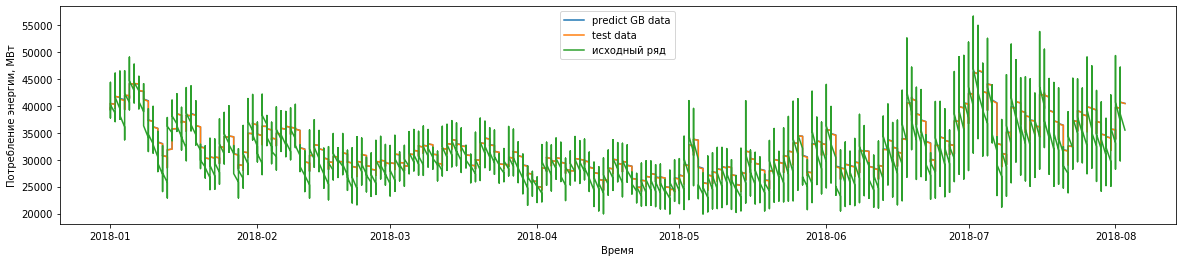

In [81]:
model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test_b.index[h:],X_test_pred_gb, label='predict GB data' )
plt.plot(test_b.index[h:],y_test_b, label='test data')
plt.plot(data.loc['2018-01-01':].index, data.loc['2018-01-01':]['PJME_MW'], label='исходный ряд')

plt.legend()
plt.show()

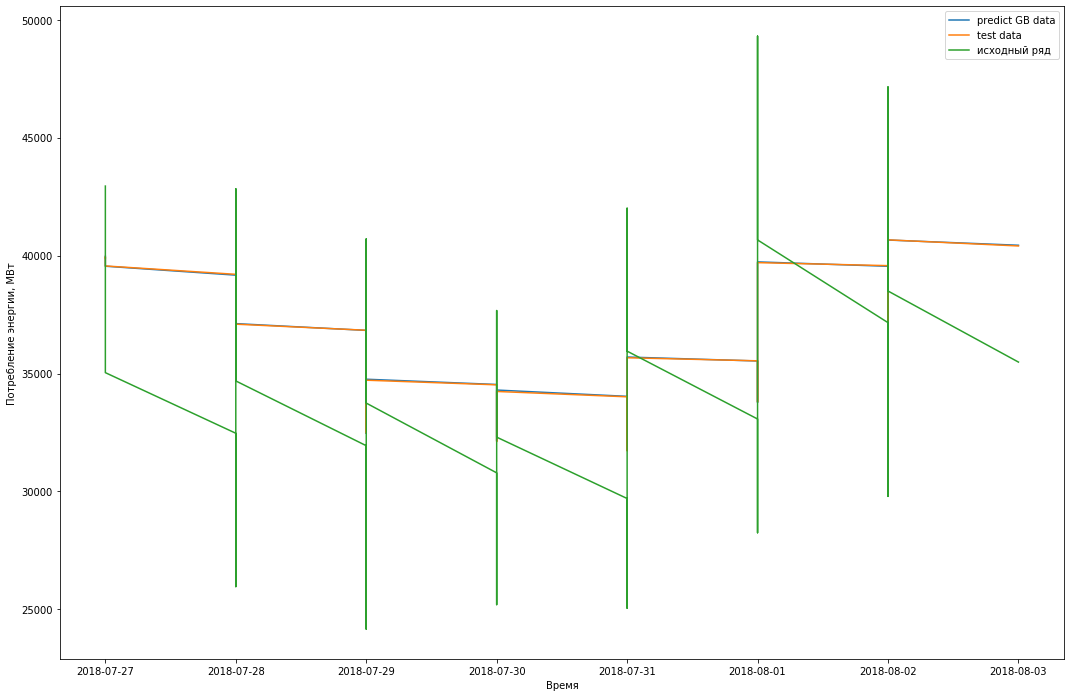

In [82]:
plt.figure( figsize=( 18, 12))

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test_b.index[-150:],X_test_pred_gb[-150:], label='predict GB data' )
plt.plot(test_b.index[-150:],y_test_b[-150:], label='test data')
plt.plot(data.iloc[-150:].index, data.iloc[-150:]['PJME_MW'], label='исходный ряд')

plt.legend()
plt.show()

**Похоже выпало время из индекса :( и внутридневное движение "склеилось" (отнесено к одному моменту времени)...**

Это должно заметно ухудшить качество модели

In [83]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [84]:
er_g_1 = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)
er_g_1

0.10117970379485165

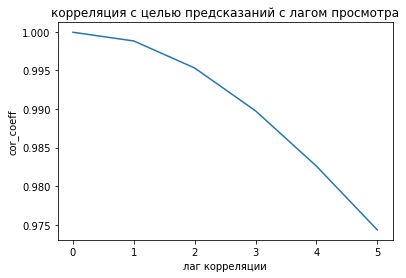

In [85]:
lag=5
p_cor=[np.corrcoef( y_test_b, X_test_pred_gb)[1,0]]
for i in range(lag):
    c=np.corrcoef( y_test_b[:-(i+1)], X_test_pred_gb[(i+1):])[1,0]
    p_cor.append(c)    

plt.plot(np.array(p_cor) ) 
plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')
plt.title('корреляция с целью предсказаний с лагом просмотра')
plt.show()

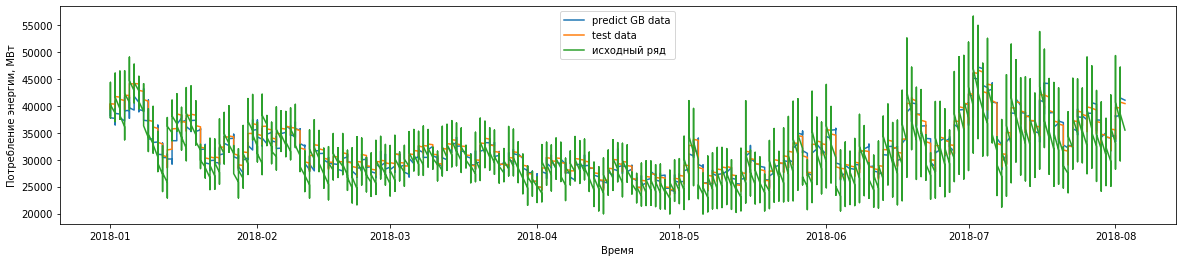

In [86]:
h = 10

X_train_b = train_b.iloc[:-h,:]
y_train_b = train_b[df.columns[0]].values[h:]
X_test_b = test_b.iloc[:-h,:]
y_test_b = test_b[df.columns[0]].values[h:]

model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test_b.index[h:],X_test_pred_gb, label='predict GB data' )
plt.plot(test_b.index[h:],y_test_b, label='test data')
plt.plot(data.loc['2018-01-01':].index, data.loc['2018-01-01':]['PJME_MW'], label='исходный ряд')

plt.legend()
plt.show()

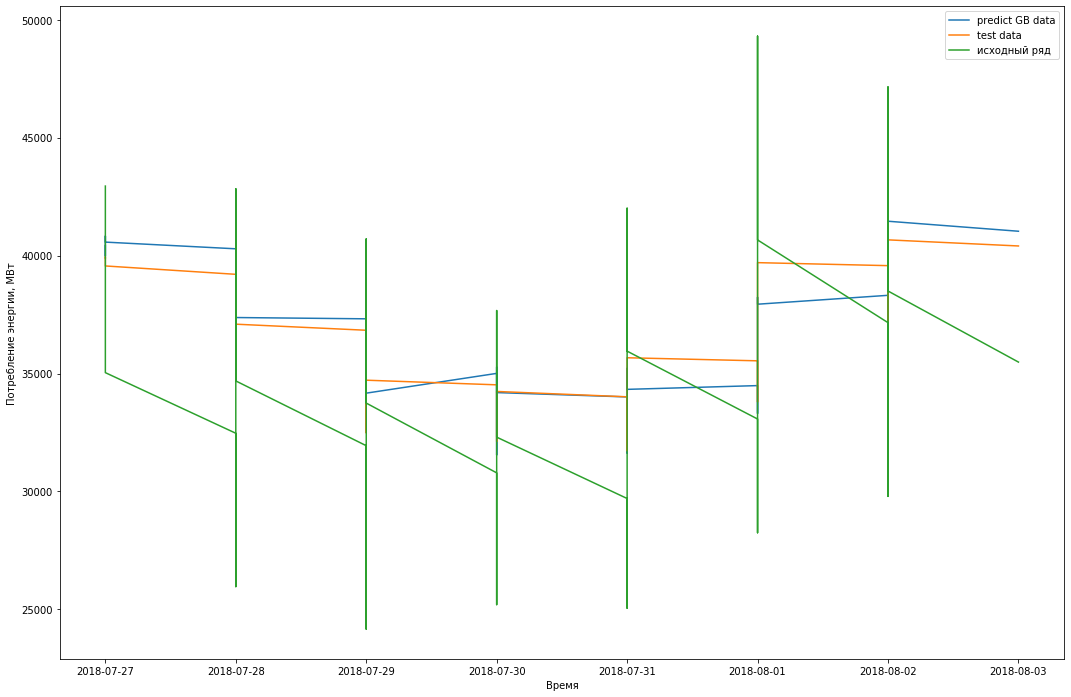

In [87]:
plt.figure( figsize=( 18, 12))

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test_b.index[-150:],X_test_pred_gb[-150:], label='predict GB data' )
plt.plot(test_b.index[-150:],y_test_b[-150:], label='test data')
plt.plot(data.iloc[-150:].index, data.iloc[-150:]['PJME_MW'], label='исходный ряд')

plt.legend()
plt.show()

In [88]:
er_g_10 = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)
er_g_10

2.620754471405572

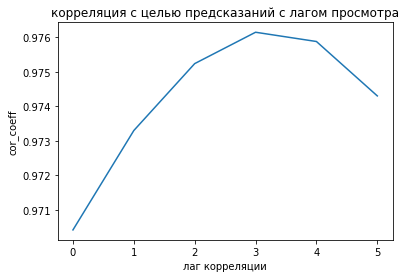

In [89]:
lag=5
p_cor=[np.corrcoef( y_test_b, X_test_pred_gb)[1,0]]
for i in range(lag):
    c=np.corrcoef( y_test_b[:-(i+1)], X_test_pred_gb[(i+1):])[1,0]
    p_cor.append(c)    

plt.plot(np.array(p_cor) ) 
plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')
plt.title('корреляция с целью предсказаний с лагом просмотра')
plt.show()

## Задание № 2

2.Оцените ошибку модели из п.1 .

In [90]:
print(f'ошибка градиентного бустинга при h = 1:  {er_g_1} %')
print(f'ошибка градиентного бустинга при h = 10: {er_g_10} %')

ошибка градиентного бустинга при h = 1:  0.10117970379485165 %
ошибка градиентного бустинга при h = 10: 2.620754471405572 %


## Задание № 3

3.Сделайте вывод о том, как изменилась ошибка модели по значениям h.

Похоже выпало время из индекса :( и внутридневное движение "склеилось" (отнесено к одному моменту времени)... Это должно заметно ухудшить качество модели

При увеличении горизонта прогрноза с 1 до 10 часов значительно возрасла ошибка с 0.1011 до 2.6207 в предсказываемом значении. Однако, по сравнению с увеличением ошибки на Brent(с 0.4956 до 4.8315) точность осталась на более высоком уровне, что обусловлено и большей стабильностью процесса и большим объёмом данных.

## Задание № 4

4.Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):

**а) Изменение температуры за окном :)**

**Нестационарный.** Наличие сезонных изменений изменяется матожидание в течение года

**б) Количество денег, которые тратят покупатели в интернет магазине**

Накладывается много факторов и ряд мог бы быть стационарным, но тоже должна быть сезонность (особенно если товар сезонный, например садовый инвентарь, ёлочные украшения и т.д.). Будем считать **нестационарным** из-за сезонности (покупки к праздникам) и влияния маркетинговых факторов, например скидок, распродаж (изменится и матожидание и дисперсия)

**в) Вес растущего котенка**

**Нестацинарный.** Ярко выраженный тренд

**г) Прирост объема деревьев в лесу от времени**

Деревья в лесу растут и в старых лесах объём (что бы это ни значило) д.б. заметно больше чем в молодых. Должен быть тренд т.е. ряд **нестационарный.** Однако с определённого момента рост достигает насыщения (деревья не растут бесконечно). Леса страдают от вредителей, пожаров, гроз, ураганов. Подростает молодая поросль. И процесс на некотором участке (не рассматриваем рост в ширину) може приобрести **стационарный** характер.

**П р и м е ч а н и е:** самый стационарный ряд - это белый шум.